In [1]:
import dicom
import pylab
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import scipy.misc
from scipy.misc import imsave
import numpy as np

from keras.applications import vgg16
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Reshape, Dropout
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.layers import Input, Dense
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import os

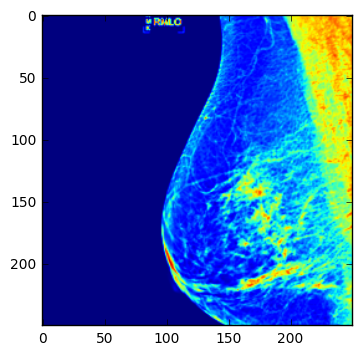

In [3]:
img = load_img(path='./png_images/000138.dcm.png', grayscale=True)

plt.imshow(img)
plt.show()

In [4]:
img = img_to_array(img)
img = np.dstack([img[:,:,0],img[:,:,0],img[:,:,0]])

In [5]:
def preprocess_image(img):
    img = img_to_array(img)
    img = np.dstack([img[:,:,0],img[:,:,0],img[:,:,0]])
    img = np.expand_dims(img, axis=0)
    return img

In [6]:
ppimg = preprocess_image(img)

In [7]:
ppimg.shape

(1, 250, 250, 3)

In [8]:
ylabels = ["cancerL","cancerR","invL","invR","age","implantEver","implantNow","bcHistory","yearsSincePreviousBc","previousBcLaterality","reduxHistory","reduxLaterality","hrt","antiestrogen","firstDegreeWithBc","firstDegreeWithBc50","bmi","race"
]

In [9]:
# read data files
import csv



In [10]:
outcomes = {}
with open('data/exams_metadata_pilot_20160906.tsv') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    def try_int(e):
        try:
            return int(e)
        except:
            return 0.5
    def onehot(n, e=0):
        v = np.zeros((1,n))
        v[0,e] = 1
        return v
    
    next(reader)
    for row in reader:
            eid = tuple([int(x) for x in row[:2]])
            cancer = np.array([float(try_int(x)) for x in row[3:7]]).reshape(1,4)
            age = np.array([int(row[6])])
            redux = np.array([float(try_int(x)) for x in row[13:14]])
            redux_lat = np.array([float(try_int(x)) for x in row[14:15]])
            try:
                i = int(row[14])
                redux_lat = onehot(2,i-1)
            except ValueError:
                redux_lat = np.zeros((1,2))
            except IndexError:
                redux_lat = np.ones((1,2))
            
            treatment = np.array([float(x) if float(x)<=1 else 0.5 for x in row[15:17]]).reshape(1,2)
            race = onehot(9, int(row[-1])-1 )

            outcomes[eid] = {'cancer': cancer,
                             #'age':age,
                             'reductions': redux,
                             'reduction_laterality': redux_lat,
                             'treatments':treatment,
                             'race':race}

In [11]:
name='drop1last5VGG16stack'

In [12]:
with tf.device('/gpu:0'):
    vgg16_model = vgg16.VGG16(include_top=False,weights='imagenet', input_shape=(250,250,3))
    #for i,layer in enumerate(vgg16_model.layers):
    #    print(i, layer.output_shape, layer.name)
    for layer in vgg16_model.layers[:-5]:
        layer.trainable = False
        
    #Adding specialized layers 
    x = vgg16_model.output
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    #Adding different output layers
    #age_prediction = Dense(1,name='age)(x)
    reduction_prediction = Dense(1, activation="sigmoid",name='reduction')(x)
    reduction_lat_prediction = Dense(2, activation="softmax", name='reduction_lat')(x)
    treatment_prediction = Dense(2, activation="sigmoid", name='treatment')(x)
    race_prediction = Dense(9, activation='softmax',name='race')(x)
    cancer_prediction = Dense(4, activation="sigmoid",name='cancer')(x)
    
    # creating the entire model 
    model = Model(input = vgg16_model.input, output = [#age_prediction, 
                                                      reduction_prediction, 
                                                      reduction_lat_prediction,
                                                      treatment_prediction,
                                                      race_prediction,
                                                      cancer_prediction])
    # compile the model 
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
                  loss=[#'mean_squared_error',
                        'binary_crossentropy',
                        'categorical_crossentropy',
                        'binary_crossentropy',
                        'categorical_crossentropy',
                        'binary_crossentropy'],
                  loss_weights=[0.125,0.125,0.125,0.125,0.5],
                  metrics=['accuracy'])
    
    model.summary()
    

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 250, 250, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 250, 250, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 250, 250, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 125, 125, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

/home/rudolf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [13]:
def generator(verbose=False, filepath='data/training.tsv'):
    if verbose:
        from IPython.display import clear_output
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        next(reader)
        lines = list(reader)
        n = len(lines)
        i = -1
        while True:
            i = i+1
            row = lines[i%n]
            subjectId,examIndex,imageIndex,*_,filename,cancer = row
            img = load_img(path='./png_images/%s.png'%(filename), grayscale=True)
            if verbose:
                clear_output()
                print('Processing')
                plt.imshow(img)
                plt.show()
            img = preprocess_image(img)
            eid = tuple([int(x) for x in row[:2]])
            y = outcomes[eid]
            yield img,[ #y['age'],
                        y['reductions'],
                        y['reduction_laterality'],
                        y['treatments'],
                        y['race'], 
                        y['cancer']]

In [14]:
from keras.callbacks import Callback
class TestCallback(Callback):
    def __init__(self):
        self.generator = generator(filepath='data/test.tsv')
        self.logs = {}
        self.evaluations = {}
    def on_epoch_end(self, epoch, logs={}):
        evals = self.model.evaluate_generator(self.generator,32)
        self.logs[epoch] = logs
        self.evaluations[epoch] = evals
        #print('\nEpoch: {} Testing loss: {}, acc: {}\n'.format(epoch, losses, acc))

In [15]:
cb = TestCallback()
model.fit_generator(generator(),
                    samples_per_epoch=4, 
                    nb_epoch=400,
                    verbose=1,
                    callbacks=[cb])

/home/rudolf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
/home/rudolf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=4, epochs=400, verbose=1, callbacks=[<__main__...)`


Epoch 1/400
4/4 [==============================] - 4s - loss: 1.3683 - reduction_loss: 1.1324 - reduction_lat_loss: -0.0000e+00 - treatment_loss: 1.3371 - race_loss: 1.2707 - cancer_loss: 1.8016 - reduction_acc: 0.0000e+00 - reduction_lat_acc: 0.7500 - treatment_acc: 0.5000 - race_acc: 0.7500 - cancer_acc: 0.3125     
Epoch 2/400
4/4 [==============================] - 2s - loss: 2.0195 - reduction_loss: 4.8707 - reduction_lat_loss: -0.0000e+00 - treatment_loss: 0.3109 - race_loss: 6.5552 - cancer_loss: 1.1048 - reduction_acc: 0.2500 - reduction_lat_acc: 0.5000 - treatment_acc: 0.8750 - race_acc: 0.0000e+00 - cancer_acc: 0.6250     
Epoch 3/400
4/4 [==============================] - 2s - loss: 1.4013 - reduction_loss: 1.6698 - reduction_lat_loss: -0.0000e+00 - treatment_loss: 1.1352 - race_loss: 3.0660 - cancer_loss: 1.3348 - reduction_acc: 0.0000e+00 - reduction_lat_acc: 0.2500 - treatment_acc: 0.0000e+00 - race_acc: 0.0000e+00 - cancer_acc: 0.6875     
Epoch 4/400
4/4 [===============

In [16]:
reduction_acc,reduction_loss,reduction_lat_acc,reduction_lat_loss,treatment_acc,treatment_loss,race_acc,race_loss,cancer_acc,cancer_loss,loss=[],[],[],[],[],[],[],[],[],[],[]

In [17]:
logs = cb.logs
epochs = []
for epoch, log in logs.items():
    epochs.append([epoch])
    reduction_acc.append(log['reduction_acc'])
    reduction_loss.append(log['reduction_loss'])
    reduction_lat_acc.append(log['reduction_lat_acc'])
    reduction_lat_loss.append(log['reduction_lat_loss'])
    treatment_acc.append(log['treatment_acc'])
    treatment_loss.append(log['treatment_loss'])
    race_acc.append(log['race_acc'])
    race_loss.append(log['race_loss'])
    cancer_acc.append(log['cancer_acc'])
    cancer_loss.append(log['cancer_loss'])
    loss.append(log['loss'])

In [18]:
import matplotlib.pyplot as plt
import pylab

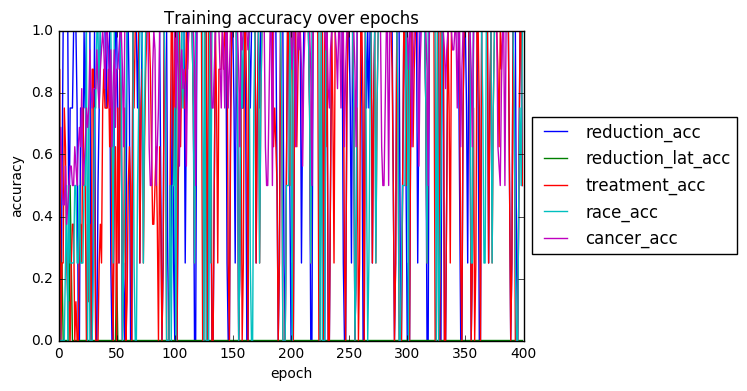

In [19]:
plt.plot(epochs, reduction_acc)
plt.plot(epochs, reduction_lat_acc)
plt.plot(epochs, treatment_acc)
plt.plot(epochs, race_acc)
plt.plot(epochs, cancer_acc)
plt.legend(['reduction_acc', 'reduction_lat_acc', 'treatment_acc', 'race_acc', 'cancer_acc'],loc='center left',bbox_to_anchor=(1, 0.5))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Training accuracy over epochs')
plt.savefig('research_data/training_acc_%s.png'%name, bbox_inches = 'tight')
plt.show()

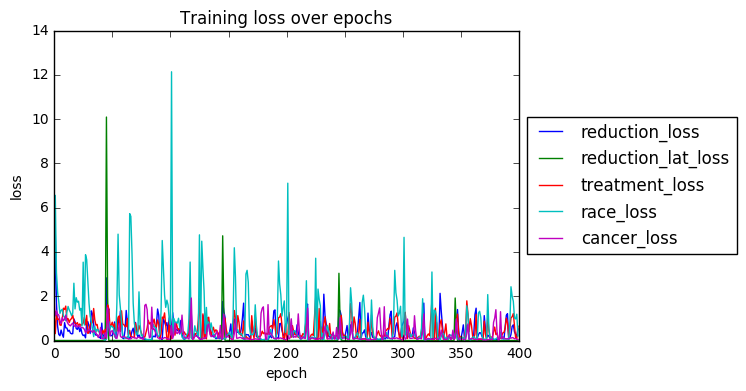

In [20]:
plt.plot(epochs, reduction_loss)
plt.plot(epochs, reduction_lat_loss)
plt.plot(epochs, treatment_loss)
plt.plot(epochs, race_loss)
plt.plot(epochs, cancer_loss)
plt.legend(['reduction_loss', 'reduction_lat_loss', 'treatment_loss', 'race_loss', 'cancer_loss'],loc='center left',bbox_to_anchor=(1, 0.5))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training loss over epochs')
plt.ylim(0, 14)
plt.savefig('research_data/training_loss_%s.png'%name, bbox_inches = 'tight')
plt.show()


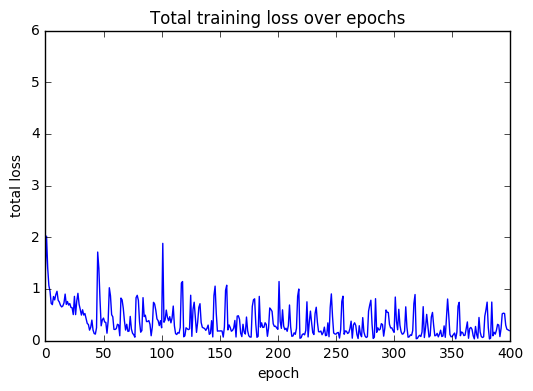

In [21]:
plt.plot(epochs, loss)
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total training loss over epochs')
plt.ylim(0, 6)
plt.savefig('research_data/total_training_loss_%s.png'%name, bbox_inches = 'tight')
plt.show()

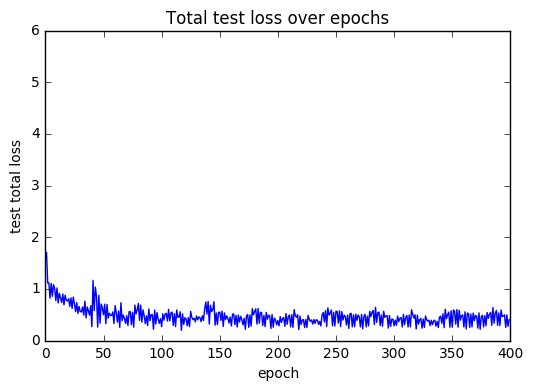

In [22]:
test_total_loss = [ cb.evaluations[e[0]][0] for e in epochs]


plt.plot(epochs, test_total_loss)
plt.xlabel('epoch')
plt.ylabel('test total loss')
plt.title('Total test loss over epochs')
plt.ylim(0, 6)
plt.savefig('research_data/total_test_loss_%s.png'%name, bbox_inches = 'tight')
plt.show()

In [23]:
import json

with open('logs_%s.json'%name, 'w') as fp:
    json.dump(cb.logs, fp)
with open('evals_%s.json'%name, 'w') as fp:
    json.dump(cb.evaluations, fp) 
with open('evaluation_%s.txt'%name, 'w') as fp:
    fp.write('%s'%(str(model.evaluate_generator(generator(filepath='data/test.tsv'),100))))

In [24]:
predicted = model.predict_generator(generator(filepath='data/training.tsv'),400)

In [25]:
from gtts import gTTS
import os
tts = gTTS(text="The experiment is done!", lang='en-uk')
tts.save("done.mp3")
os.system("mpg321 done.mp3")

0

In [26]:
model.metrics_names

['loss',
 'reduction_loss',
 'reduction_lat_loss',
 'treatment_loss',
 'race_loss',
 'cancer_loss',
 'reduction_acc',
 'reduction_lat_acc',
 'treatment_acc',
 'race_acc',
 'cancer_acc']